In [82]:
# Author: Vamshi Chenna - Week 1
# Revised by: Shiva Deviah - Week 3
import matplotlib.pyplot as plt
import pandas as pd
import re
import os

from pyspark import SparkContext, SparkConf 
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

try:
    del os.environ['PYSPARK_SUBMIT_ARGS']
except KeyError:
    pass

conf = SparkConf().setAppName("eda").setMaster("local[*]")                                                     
sc = SparkContext(conf=conf)

In [1]:
pattern = re.compile(r'Restaurant|Alcohol')
def is_valid_attr(dct):
    return any(pattern.match(k) for k in dct.keys())

business_json_df = (pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)
                      .dropna(subset=['attributes']))

#Get the restuarant Data from the businesses
mask = (business_json_df['attributes'].map(is_valid_attr) 
        | business_json_df['categories'].str.contains(r"Food|Restaurant|Bar", case=False) 
        | business_json_df['name'].str.contains("Restaurant|Cuisine", case=False))
business_json_df = business_json_df[mask]

business_json_df.shape

(113202, 15)

In [6]:
attrDF = pd.DataFrame(business_json_df.attributes.dropna().tolist())
#Gets the individual count for every attribute
attrDF.count()

AcceptsInsurance                2811
AgesAllowed                      396
Alcohol                        47892
Ambience                       47569
BYOB                             911
BYOBCorkage                     1409
BestNights                      6842
BikeParking                    78905
BusinessAcceptsBitcoin          7594
BusinessAcceptsCreditCards    101443
BusinessParking                96813
ByAppointmentOnly              20214
Caters                         40038
CoatCheck                       8527
Corkage                          657
DietaryRestrictions              138
DogsAllowed                    12490
DriveThru                       6754
GoodForDancing                  9158
GoodForKids                    56618
GoodForMeal                    47483
HairSpecializesIn               1683
HappyHour                       9279
HasTV                          47527
Music                           8803
NoiseLevel                     43704
Open24Hours                      350
O

In [9]:
#To Caliculate averages and attribute density,
attrDensity = attrDF.count(axis=1)

#Gets the number of business having attributes more than 1
attrDensity[attrDensity>1].size

111767

In [10]:
#Get the average of attributes per business

#Avergage number of attributes per Resturant : 11.338933217616168
#Resturants which have atlest one attribute : 112919
#Restuarants having more than one attribute : 111549
#Resturants having more than three attributes : 101870
#Resturants having more than five attributes : 76988
#Resturants having more than ten attributes : 50864

attrDensity.mean()

11.320171021713398

In [13]:
#Categories-----------------------------------------------------------------------------------------
categories = business_json_df.categories.dropna().str.split(r'\s*,\s*', expand=True)
#Get the categories count per user
catcount = categories.count(axis=1)

catcount.head()

0    6
1    9
2    5
5    2
6    2
dtype: int64

In [14]:
#Get the mean of the no of categories
categories.count(axis=1).mean()

4.043264260151107

In [15]:
#Gets the number of business having categories more than 1
catcount[catcount>1].size

112649

In [16]:
#Average category per resturant : 4.0274109643857541
#Restuarants having atlest one category : 114954
#Restuarants having more than one category : 114390
#Restuarants having more than two categories : 82534

#Shopping	24503
#Beauty & Spas	15956
#Nightlife	12147
#Bars	10853
#Coffee & Tea	6936


#Reviews-----------------------------------------------------------------------------------------

#Average No of Reviews for a busineses : 43.107634782608699
#Minimum no of reviews for a resturant : 3

#Restuarants having atlest 10 reviews : 65719
#Restuarants having more than 15 reviews : 52183
#Restuarants having more than 20 reviews : 42111
#Resturants having more than 25 reviews : 36274
#Resturants having more than 30 reviews : 31881


business_json_df.review_count.mean()

43.72633875726577

# Analysing Features

In [108]:
# Define two types of features:
# 1. Essential
# 2. Informative
# Essential are deemed necessary to facilitate a basic prediction
# Informative indicate useful signals in determining the rating of a restaurant.
pattern = re.compile(r'Restaurant|Alcohol')
def is_valid_attr(dct):
    return any(pattern.match(k) for k in dct.keys())

business_json_df = (pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)
                       # Set the index to business_id; this will be used for joining later.
                      .set_index('business_id')
                      .dropna(subset=['attributes']))
# Filter out non-restaurant businesses.
mask = (business_json_df['categories'].str.contains(r"Food|Restaurant|Bar", case=False) 
        | business_json_df['name'].str.contains("Restaurant|Cuisine", case=False))
business_json_df = business_json_df[mask]

In [109]:
attributes = business_json_df.pop('attributes')
attr_df = pd.DataFrame(attributes.tolist(), index=attributes.index)

attr_df.head()

,AcceptsInsurance,AgesAllowed,Alcohol,Ambience,BYOB,BYOBCorkage,BestNights,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,...,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
business_id,,,,,,,,,,,,,,,,,,,,,
Apn5Q_b6Nz61Tq4XzPdf9A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True,...,NaN,False,True,2,True,NaN,True,NaN,NaN,NaN
AjEbIBw6ZFfln7ePHha9PA,NaN,NaN,none,NaN,NaN,NaN,NaN,False,NaN,True,...,NaN,False,True,2,False,False,True,NaN,True,no
O8S5hYJ1SMc8fA4QBtVujA,NaN,NaN,beer_and_wine,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,NaN,False,...,NaN,False,True,2,True,True,False,NaN,NaN,free
45bWSZtniwPRiqlivpS8Og,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,...,NaN,NaN,NaN,1,NaN,NaN,True,NaN,True,free
9A2quhZLyWk0akUetBd8hQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
idx = business_json_df.loc[business_json_df.categories.astype(str).str.contains('Shopping')].index[0]

In [111]:
s = attr_df.loc[idx]
s[s.index.str.contains('Restaurant|Alcohol')]

Alcohol                        NaN
RestaurantsAttire              NaN
RestaurantsCounterService      NaN
RestaurantsDelivery          False
RestaurantsGoodForGroups       NaN
RestaurantsPriceRange2           1
RestaurantsReservations        NaN
RestaurantsTableService        NaN
RestaurantsTakeOut            True
Name: bwZqlLj8oYaML3ndlybeDg, dtype: object

In [112]:
import ast

mult_cols = ['Ambience', 'BusinessParking', 'GoodForMeal']
mult_df = []
for c in mult_cols:
    df = attr_df[c].dropna()
    df = (pd.DataFrame(df.apply(ast.literal_eval).tolist(), 
                       index=df.index)
            .rename(lambda x: '{0}_{1}'.format(c, x), axis=1)
            .reindex(attr_df.index))

    mult_df.append(
            df
        )
    
mult_df = (pd.concat(mult_df, axis=1)
             .replace({'True': '1', 'False': '0'})
             .astype(float))
mult_df.head()

,Ambience_casual,Ambience_classy,Ambience_divey,Ambience_hipster,Ambience_intimate,Ambience_romantic,Ambience_touristy,Ambience_trendy,Ambience_upscale,BusinessParking_garage,BusinessParking_lot,BusinessParking_street,BusinessParking_valet,BusinessParking_validated,GoodForMeal_breakfast,GoodForMeal_brunch,GoodForMeal_dessert,GoodForMeal_dinner,GoodForMeal_latenight,GoodForMeal_lunch
business_id,,,,,,,,,,,,,,,,,,,,
Apn5Q_b6Nz61Tq4XzPdf9A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
AjEbIBw6ZFfln7ePHha9PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O8S5hYJ1SMc8fA4QBtVujA,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45bWSZtniwPRiqlivpS8Og,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
9A2quhZLyWk0akUetBd8hQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
elevation_df = (pd.read_csv("yelp_dataset/altitude.csv", usecols=['business_id', 'elevation'])
                 .set_index('business_id'))

review_df = (pd.read_csv('yelp_dataset/review_normalized.csv', header=None, names=['business_id', 'rating'])
                .set_index('business_id'))

bool_cols = ['BikeParking', 'BusinessAcceptsCreditCards', 'Caters', 'GoodForKids', 
             'HasTV', 'OutdoorSeating', 'RestaurantsDelivery', 'RestaurantsGoodForGroups',
             'RestaurantsReservations', 'RestaurantsTableService', 'RestaurantsTakeOut', 
             'WheelchairAccessible']
bool_df = attr_df[bool_cols].replace({'True': '1', 'False': '0'}).astype(float)

In [114]:
cat_cols = ['Alcohol', 'NoiseLevel', 'RestaurantsAttire', 'RestaurantsPriceRange2', 'WiFi']

business_json_df2 = (
    business_json_df[['categories']]
        .join(review_df)
        .join(elevation_df)
        # .join(mult_df)
        .join(attr_df[cat_cols])
        .join(bool_df)
        .sort_index(axis=1))

business_json_df2.head()

,Alcohol,BikeParking,BusinessAcceptsCreditCards,Caters,GoodForKids,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WheelchairAccessible,WiFi,categories,elevation,rating
business_id,,,,,,,,,,,,,,,,,,,,
Apn5Q_b6Nz61Tq4XzPdf9A,NaN,0.0,1.0,NaN,1.0,1.0,average,0.0,casual,0.0,1.0,2,1.0,NaN,1.0,NaN,NaN,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",1076.0,0.117806
AjEbIBw6ZFfln7ePHha9PA,none,0.0,1.0,1.0,1.0,0.0,NaN,1.0,casual,0.0,1.0,2,0.0,0.0,1.0,1.0,no,"Chicken Wings, Burgers, Caterers, Street Vendo...",992.0,0.028369
O8S5hYJ1SMc8fA4QBtVujA,beer_and_wine,1.0,0.0,0.0,1.0,1.0,average,0.0,casual,0.0,1.0,2,1.0,1.0,0.0,NaN,free,"Breakfast & Brunch, Restaurants, French, Sandw...",67.0,-0.041573
45bWSZtniwPRiqlivpS8Og,NaN,1.0,1.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1,NaN,NaN,1.0,1.0,free,"Coffee & Tea, Food",462.0,0.178532
9A2quhZLyWk0akUetBd8hQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,"Food, Bakeries",113.0,0.517542


In [87]:
from sklearn.preprocessing import StandardScaler, Imputer, MinMaxScaler

def freq_encode(ser):
    return ser.map(ser.value_counts(normalize=True))

df_ = business_json_df2.copy(deep=True)
df_.drop('categories', axis=1, inplace=True)
df_[cat_cols] = df_[cat_cols].apply(freq_encode)

c = df_.select_dtypes(include=[object]).columns

y = MinMaxScaler((1, 10)).fit_transform(df_.pop('rating')[:, None])
X = df_.values

X[:10, :10], y[:10]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarni

(array([[       nan, 0.        , 1.        ,        nan, 1.        ,
         1.        , 0.65044556, 0.        , 0.96902444, 0.        ],
        [0.45136723, 0.        , 1.        , 1.        , 1.        ,
         0.        ,        nan, 1.        , 0.96902444, 0.        ],
        [0.13884469, 1.        , 0.        , 0.        , 1.        ,
         1.        , 0.65044556, 0.        , 0.96902444, 0.        ],
        [       nan, 1.        , 1.        , 0.        ,        nan,
                nan,        nan, 1.        ,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan],
        [0.45136723,        nan, 1.        ,        nan, 1.        ,
                nan,        nan, 0.        , 0.96902444,        nan],
        [0.45136723, 1.        , 1.        , 0.        , 1.        ,
         0.        , 0.65044556, 0.        , 0.96902444, 0.        ],
        [       nan,       

In [88]:
import xgboost as xgb

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split 

print('XGBoost Version:', xgb.__version__)

_X_sparse = csr_matrix(X)

data_dmatrix = xgb.DMatrix(data=_X_sparse, label=y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarni

XGBoost Version: 0.80


In [89]:
params = dict(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.25,
                max_depth=4, reg_alpha=10, n_estimators=150, n_jobs=-1, silent=True)

data_dmatrix = xgb.DMatrix(data=df_, label=y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=0)

cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,4.217440,0.000602,4.217437,0.003222
1,3.228371,0.000361,3.228322,0.003522
2,2.504774,0.000301,2.504926,0.003825
3,1.984518,0.000709,1.984837,0.004284
4,1.619544,0.000613,1.620081,0.004183


In [90]:
cv_results["test-rmse-mean"].tail(1) # Best RMSE

49    0.936525
Name: test-rmse-mean, dtype: float64

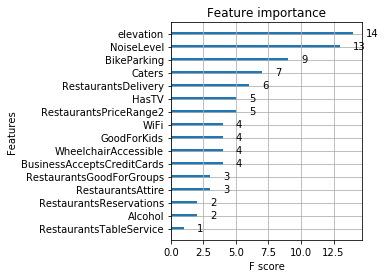

In [92]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

xgb.plot_importance(xg_reg, ax=ax)
plt.axis('scaled')
plt.show()

In [ ]:
# Features to use 
# elevation, NoiseLevel, RestaurantsDelivery, HasTV, RestaurantsPriceRange2, 'WiFi', 'GoodForKids', 'WheelChairAccessible'
# 'BusinessAcceptsCreditCards', 'Alcohol', 'RestaurantsGoodForGroups'
#
#

In [140]:
# Impute data and perform PCA.
filled = Imputer(strategy='most_frequent').fit_transform(df_.values) 
data = filled - filled.mean(axis=0)

S = data.T.dot(data) / data.shape[0]
v, U = np.linalg.eig(S)

In [141]:
df_.columns[-np.argsort(v)]

Index(['RestaurantsPriceRange2', 'RestaurantsGoodForGroups',
       'RestaurantsDelivery', 'OutdoorSeating', 'NoiseLevel', 'GoodForKids',
       'Caters', 'BusinessAcceptsCreditCards', 'BikeParking', 'HasTV',
       'RestaurantsAttire', 'RestaurantsReservations',
       'RestaurantsTableService', 'RestaurantsTakeOut', 'WheelchairAccessible',
       'WiFi', 'elevation', 'Alcohol'],
      dtype='object')

In [ ]:
from sklearn.feature_selection import RFE

estimator = xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.25,
                max_depth=4, reg_alpha=10, n_estimators=100, n_jobs=-1)

selector = RFE(estimator, 10, step=1)
selector = selector.fit(filled, y.ravel())

In [151]:
print(df_.columns[selector.support_])
print(selector.ranking_[selector.support_])

Index(['Alcohol', 'BikeParking', 'HasTV', 'NoiseLevel', 'RestaurantsDelivery',
       'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'WheelchairAccessible',
       'WiFi', 'elevation'],
      dtype='object')
[1 1 1 1 1 1 1 1 1 1]


### Exploring Categories

In [201]:
cats = business_json_df2.loc[:, 'categories']

In [202]:
v = cats.str.split(', ',expand=True).stack()

In [203]:
valcnt = v.value_counts()
valcnt = valcnt[valcnt.gt(100)]
valcnt.index.to_series().to_frame('category').to_csv('yelp_dataset/cat100.csv', index=False)

In [204]:
import re

cats = valcnt.index.dropna()
temp = business_json_df2.dropna(subset=['categories'])
temp = temp[[any(c in x for c in cats) for x in temp['categories']]]
temp.head()

,Alcohol,BikeParking,BusinessAcceptsCreditCards,Caters,GoodForKids,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WheelchairAccessible,WiFi,categories,elevation,rating
business_id,,,,,,,,,,,,,,,,,,,,
Apn5Q_b6Nz61Tq4XzPdf9A,NaN,0.0,1.0,NaN,1.0,1.0,average,0.0,casual,0.0,1.0,2,1.0,NaN,1.0,NaN,NaN,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",1076.0,0.117806
AjEbIBw6ZFfln7ePHha9PA,none,0.0,1.0,1.0,1.0,0.0,NaN,1.0,casual,0.0,1.0,2,0.0,0.0,1.0,1.0,no,"Chicken Wings, Burgers, Caterers, Street Vendo...",992.0,0.028369
O8S5hYJ1SMc8fA4QBtVujA,beer_and_wine,1.0,0.0,0.0,1.0,1.0,average,0.0,casual,0.0,1.0,2,1.0,1.0,0.0,NaN,free,"Breakfast & Brunch, Restaurants, French, Sandw...",67.0,-0.041573
45bWSZtniwPRiqlivpS8Og,NaN,1.0,1.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1,NaN,NaN,1.0,1.0,free,"Coffee & Tea, Food",462.0,0.178532
9A2quhZLyWk0akUetBd8hQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,"Food, Bakeries",113.0,0.517542


In [234]:
cats2 = {'Spanish', 'Portuguese', 'Latin American', 'African', 'Japanese', 'Chinese', 'Indian', 
         'Pakistani', 'Peruvian', 'French', 'Italian', 'Brazillian', 'British', 'German',
         'Korean', 'Vietnamese', 'Asian Fusion', 'Taiwanese', 'Thai', 'Greek', 'Mediterranean', 'Filipino',
         'Persian/Iranian', 'Lebanese', 'Turkish', 'American (New)', 
         'American (Traditional)', 'Middle Eastern', 'Caribbean', 'Hawaiian', 
         'Canadian (New)', 'Irish'}
# Number of data points with just these high level (regional cusine categories) - Roughly 50%
v = pd.Series([sum(c in x for c in cats2) for x in temp['categories']])
v.gt(0).sum()

31074

In [130]:
len(cats2)

34

#### SVD
Perform SVD on the categories in an attempt to hierarchically organize business categories.
We reduce 185 categories to 34 (regional).

In [205]:
v = (temp['categories']
         .str.split(r'\s*,\s*', expand=True)
         .stack()
         .reset_index(level=1, drop=True)
         .to_frame('categories')
         .assign(rating=temp['rating']))

cats = (set(pd.read_csv('yelp_dataset/cat100.csv', squeeze=True).unique()) 
        - cats2 
        - {'Food', 'Restaurants'})
v = v[v['categories'].isin(cats)]
v.head()

,categories,rating
business_id,,
Apn5Q_b6Nz61Tq4XzPdf9A,Breweries,0.117806
Apn5Q_b6Nz61Tq4XzPdf9A,Pizza,0.117806
Apn5Q_b6Nz61Tq4XzPdf9A,Hotels & Travel,0.117806
AjEbIBw6ZFfln7ePHha9PA,Chicken Wings,0.028369
AjEbIBw6ZFfln7ePHha9PA,Burgers,0.028369


In [187]:
unique_cats = len(cats)
print(unique_cats)

152


In [188]:
# v.groupby('categories').rating.mean().sort_values(ascending=False)
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder()
v['categories'] = le.fit_transform(v['categories'])

v2 = v.groupby(level=0).apply(lambda g: {x : y for x, y in zip(g['categories'], g['rating'])})
v2.head()

business_id
--1UhMGODdWsrMastO9DZw                            {106: 0.4084992835882635}
--7zmmkVg-IMGaXbuVd0SQ                           {18: 0.007930753735089512}
--9e1ONYQuAa-CB_Rrw7Tw    {134: 0.2434928894201785, 24: 0.2434928894201785}
--DaPTJW3-tB1vP-PfdTEg                             {17: 0.3123145212889004}
--FBCX-N37CMYDfs790Bnw    {13: 0.03270501754944336, 148: 0.0327050175494...
dtype: object

In [229]:
rdd = sc.parallelize(v2.tolist()).map(lambda x: Vectors.sparse(unique_cats, x))
rdd.cache()
sc.setCheckpointDir("checkpoint_dir/")

mat = RowMatrix(rdd)
svd = mat.computeSVD(len(cats2), computeU=True)
U = svd.U       # The U factor is a RowMatrix.
s = svd.s       # The singular values are stored in a local dense vector.
V = svd.V       # The V factor is a local dense matrix.

In [190]:
vectors = V.toArray()
vectors.shape

(152, 32)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


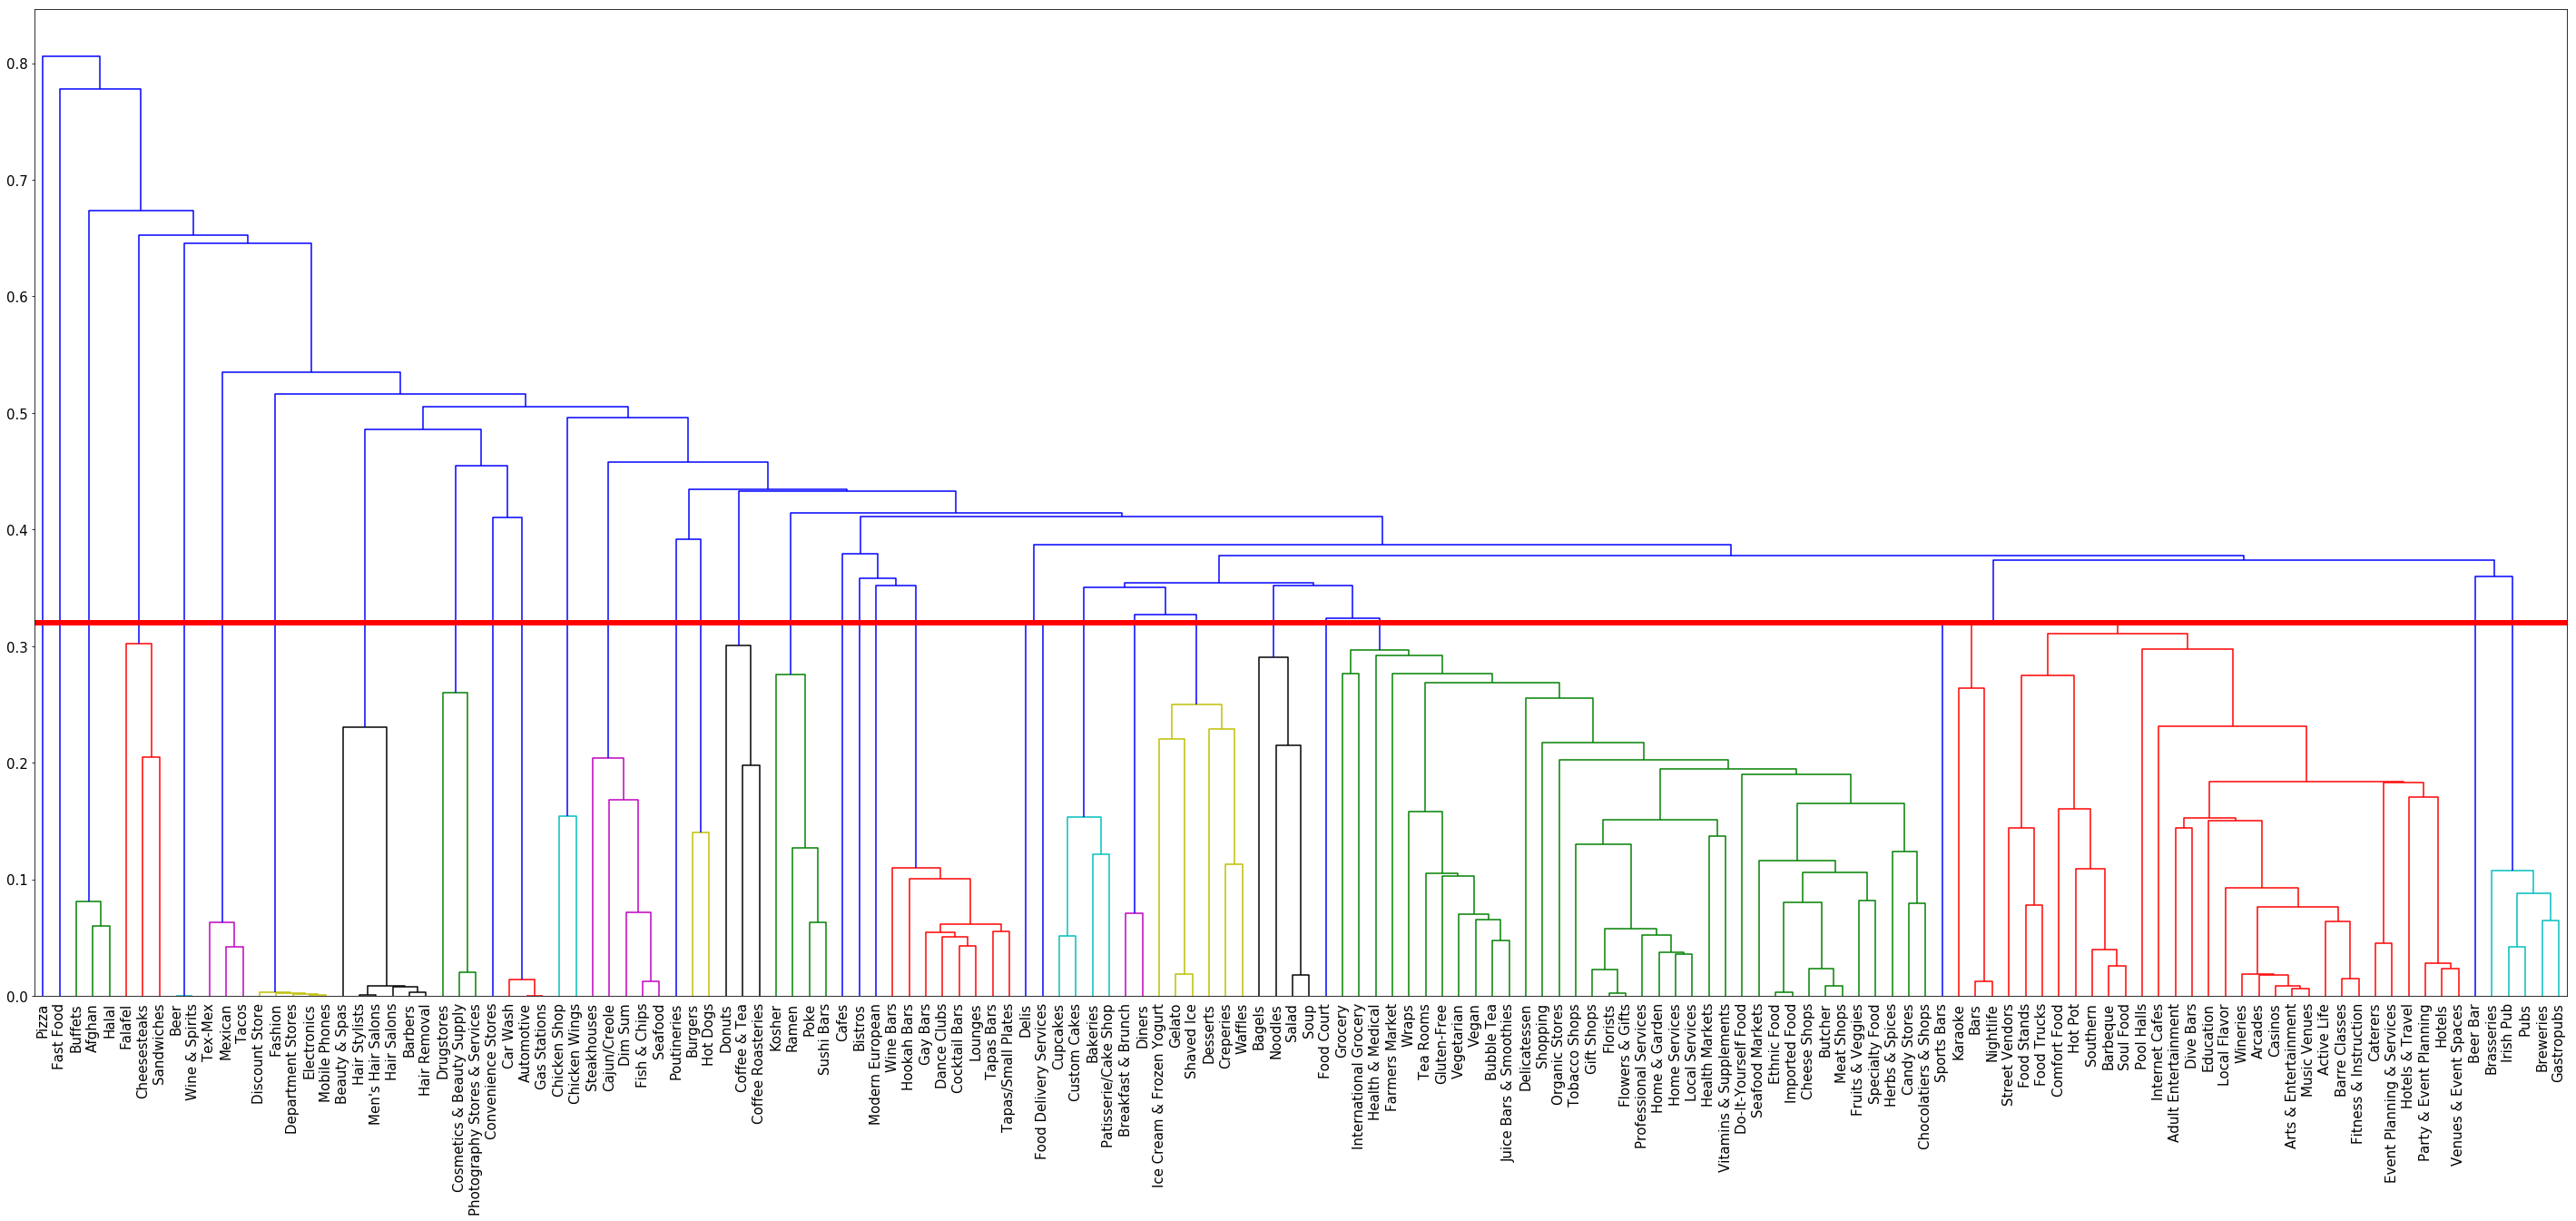

In [191]:
from scipy.cluster.hierarchy import dendrogram, linkage  

linked = linkage(vectors, 'single', 'cosine')
labelList = le.inverse_transform(np.arange(vectors.shape[0]))
plt.figure(figsize=(50, 20))  

dendrogram(linked,  
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            color_threshold=0.32,
            show_leaf_counts=True)
plt.tick_params(labelsize=15)
plt.axhline(y=0.32, linewidth=6, color='r')
plt.show()

In [218]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=len(cats2), affinity='cosine', linkage='complete')  
cat_df = pd.DataFrame({'category': labelList})
cat_df = cat_df.assign(cat34_label=cluster.fit_predict(vectors)).set_index('category').cat34_label

In [225]:
# Cluster ID mapping to business ID
cnts = valcnt.to_dict()
t = business_json_df2['categories'].map(lambda x: cats.intersection(x.split(', ')))
t = t[t.str.len().gt(0)]                     
# Resolution for multiple categories - take the one with the highest value counts in the dataset.
t = t.map(lambda x: max(x, key=cnts.get)).map(cat_df)

print(t.shape)
print(len(cats2))
t.to_frame('cat32_label').head()

(64438,)
32


,cat32_label
business_id,
Apn5Q_b6Nz61Tq4XzPdf9A,29
AjEbIBw6ZFfln7ePHha9PA,20
O8S5hYJ1SMc8fA4QBtVujA,15
45bWSZtniwPRiqlivpS8Og,5
9A2quhZLyWk0akUetBd8hQ,14


In [237]:
t2 = business_json_df2.categories.map(lambda x: cats2.intersection(x.split(', ')))
t2 = t2[t2.str.len().gt(0)]
cats2_ = list(cats2)
rcat_df = pd.Series(pd.factorize(cats2_)[0], index=cats2_)
t2 = t2.map(lambda x: max(x, key=cnts.get)).map(rcat_df)

print(t2.shape)
print(len(cats2))
t2.to_frame('catRegion_label').head()

(31037,)
32


,catRegion_label
business_id,
O8S5hYJ1SMc8fA4QBtVujA,13
6OuOZAok8ikONMS_T3EzXg,28
KapTdGyGs7RK0c68Z6hhhg,2
bBUMib8l6Me1ZB1_Qkezkg,8
r89Re4FNgVWHgBfjCVZyVw,16
